Follow this blog post
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [58]:
from gensim import corpora, models 
import numpy as np
import sys
import os
import gensim
import pickle
import nltk
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

python_root = './scripts'
sys.path.insert(0, python_root)

#### Load data

In [2]:
paras = pickle.load(open('./data/processed_corpus.p', "rb")) 

In [3]:
print(paras[0])

['1', 'as', 'a', 'small', 'open', 'tourism', 'base', 'economy', 'st._lucia', 'be', 'highly_vulnerable_to_exogenous_shock', 'tourism', 'account', 'for', 'over', 'three_quarter', 'of', 'export', 'and', 'the', 'import_content', 'of', 'both', 'consumption', 'and', 'foreign_direct_investment', 'fdi', 'be', 'very', 'high', 'figure_1', 'the', 'economy', 'have', 'be', 'buffet', 'by', 'the', 'global', 'economic', 'downturn', 'which', 'have', 'hobble', 'the', 'tourism', 'and', 'construction', 'sector', 'with', 'potential', 'spillover', 'to', 'the', 'financial', 'sector']


#### Use Gensim for topic modeling

In [4]:
## remove stop words 
norm_tokenized_corpus = paras
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.extend(['-PRON-','percent','’s','would','also',
                      'year','continue','include','give','may','new',
                      'however','well','help','since'])
norm_tokenized_corpus = [[token for token in p if token not in stopword_list] for p in norm_tokenized_corpus]

In [5]:
def _flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in _flatten(i):
                yield j
        else:
            yield i

In [6]:
words = list(_flatten(norm_tokenized_corpus))
wc = Counter(words)
wc.most_common(30)

[('authority', 118184),
 ('growth', 106963),
 ('fiscal', 106076),
 ('bank', 102460),
 ('sector', 98047),
 ('policy', 97760),
 ('gdp', 88619),
 ('increase', 84369),
 ('financial', 81209),
 ('government', 80711),
 ('reform', 77477),
 ('debt', 74619),
 ('public', 71985),
 ('rate', 69359),
 ('staff', 69139),
 ('high', 62180),
 ('remain', 58921),
 ('need', 57091),
 ('tax', 56207),
 ('program', 55408),
 ('external', 54081),
 ('economic', 52831),
 ('support', 52515),
 ('improve', 52027),
 ('market', 49549),
 ('risk', 46722),
 ('exchange', 46034),
 ('project', 45026),
 ('investment', 44747),
 ('revenue', 44276)]

In [7]:
# build dictionary

dictionary = corpora.Dictionary(norm_tokenized_corpus)
dictionary.filter_extremes(no_below=5,no_above=0.5, keep_n=10000)


# convert document into bow
corpus_bow = [dictionary.doc2bow(text) for text in norm_tokenized_corpus]
## comput tfidf feature vectors
tfidf = models.TfidfModel(corpus_bow) # smartirs = 'atc' https://radimrehurek.com/gensim/models/tfidfmodel.html
corpus_tfidf = tfidf[corpus_bow]

In [8]:
dictionary_save_path = './data/dictionary.dict'
dictionary.compactify()
dictionary.save(dictionary_save_path)
corpora.MmCorpus.serialize('./data/corpus_bow.mm', corpus_bow)
corpora.MmCorpus.serialize('./data/corpus_tfidf.mm', corpus_tfidf)

In [9]:
len(dictionary)

10000

In [10]:
## a better way to print 
def print_topics_gensim(topic_model, total_topics=1,
                        weight_threshold=0.0001,
                        display_weights=False,
                        num_terms=None):
    
    for index in range(total_topics):
        topic = topic_model.show_topic(index,topn=num_terms)
        topic = [(word, round(wt,4)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print (topic[:num_terms] if num_terms else topic)
        else:
            print ('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print (tw[:num_terms] if num_terms else tw)
        print

####  Latent Dirichlet Allocation

In [74]:
total_topics = 15

In [75]:
lda = LdaModel(corpus = corpus_bow[:50000],
                          id2word = dictionary,
                          iterations = 1000,
                          num_topics = total_topics,
                          alpha='auto',
                          eta = 'auto')#,
                          #workers = 20) #

In [76]:
print_topics_gensim(topic_model=lda,
                   total_topics = total_topics,
                   num_terms=15,
                   display_weights=True) 

Topic #1 with weights
[('debt', 0.0563), ('external', 0.0322), ('fiscal', 0.0201), ('growth', 0.013), ('policy', 0.0129), ('remain', 0.0123), ('medium_term', 0.0114), ('public', 0.0113), ('risk', 0.0108), ('high', 0.0099), ('rate', 0.0094), ('level', 0.0089), ('ratio', 0.0087), ('need', 0.0078), ('adjustment', 0.0074)]
Topic #2 with weights
[('bank', 0.1005), ('sector', 0.0304), ('credit', 0.0293), ('loan', 0.0219), ('capital', 0.0209), ('asset', 0.0201), ('lending', 0.0161), ('banking', 0.0153), ('deposit', 0.0141), ('financial', 0.0115), ('banking_system', 0.0109), ('private', 0.01), ('commercial', 0.0098), ('banks’', 0.0092), ('large', 0.0091)]
Topic #3 with weights
[('risk', 0.0334), ('financial', 0.031), ('could', 0.021), ('market', 0.0157), ('global', 0.015), ('crisis', 0.0143), ('large', 0.0122), ('u.s.', 0.0088), ('euro_area', 0.0087), ('low', 0.0085), ('growth', 0.0083), ('exposure', 0.008), ('economy', 0.008), ('potential', 0.0076), ('high', 0.0076)]
Topic #4 with weights
[('

In [77]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus_bow[:2000]))  # a measure of how good the model is. lower the better.


Perplexity:  -8.456319842134414


In [78]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=norm_tokenized_corpus[:10000], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5116850443502253


#### Topic modeling with HDP

In [59]:
hdpmodel = HdpModel(corpus = corpus_bow[:50000],id2word = dictionary)

In [60]:
hdpmodel.show_topics()

[(0,
  '0.010*fiscal + 0.009*authority + 0.008*bank + 0.008*growth + 0.008*gdp + 0.007*sector + 0.007*policy + 0.007*increase + 0.007*government + 0.006*public + 0.006*financial + 0.006*debt + 0.006*reform + 0.006*staff + 0.005*tax + 0.005*high + 0.005*need + 0.005*rate + 0.004*remain + 0.004*risk'),
 (1,
  '0.011*authority + 0.008*fiscal + 0.008*bank + 0.008*government + 0.008*sector + 0.007*reform + 0.006*public + 0.006*policy + 0.006*financial + 0.006*growth + 0.006*gdp + 0.006*tax + 0.006*increase + 0.005*program + 0.005*staff + 0.005*debt + 0.005*support + 0.005*improve + 0.005*need + 0.004*budget'),
 (2,
  '0.011*growth + 0.008*rate + 0.008*bank + 0.008*gdp + 0.008*increase + 0.007*policy + 0.007*sector + 0.006*authority + 0.006*fiscal + 0.006*high + 0.006*debt + 0.006*remain + 0.006*market + 0.006*inflation + 0.005*financial + 0.005*exchange + 0.005*external + 0.005*low + 0.004*price + 0.004*staff'),
 (3,
  '0.009*growth + 0.009*authority + 0.008*fiscal + 0.007*policy + 0.007*ba

### LSI

In [64]:
lsimodel = LsiModel(corpus = corpus_bow[:50000],id2word = dictionary,num_topics=10)

In [65]:
lsimodel.show_topics()

[(0,
  '0.225*"fiscal" + 0.217*"authority" + 0.209*"bank" + 0.208*"growth" + 0.193*"gdp" + 0.185*"sector" + 0.176*"policy" + 0.167*"increase" + 0.164*"government" + 0.157*"debt"'),
 (1,
  '-0.576*"bank" + 0.355*"gdp" + 0.283*"fiscal" + -0.264*"financial" + 0.172*"debt" + -0.161*"sector" + 0.139*"revenue" + 0.132*"growth" + 0.130*"deficit" + 0.128*"tax"'),
 (2,
  '0.351*"growth" + -0.269*"tax" + -0.248*"authority" + -0.233*"reform" + -0.225*"fiscal" + 0.211*"rate" + -0.176*"government" + 0.160*"inflation" + -0.135*"revenue" + 0.135*"exchange"'),
 (3,
  '0.401*"debt" + -0.388*"policy" + 0.325*"bank" + 0.298*"gdp" + -0.289*"rate" + -0.189*"exchange" + -0.189*"inflation" + -0.189*"monetary" + -0.167*"growth" + 0.148*"public"'),
 (4,
  '-0.447*"growth" + -0.349*"sector" + 0.273*"rate" + 0.263*"exchange" + -0.260*"reform" + 0.223*"bank" + 0.198*"fiscal" + 0.196*"policy" + 0.181*"debt" + 0.149*"monetary"'),
 (5,
  '-0.465*"debt" + 0.458*"tax" + -0.283*"fiscal" + -0.282*"policy" + 0.190*"incre

In [66]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus_bow[:10000], id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=norm_tokenized_corpus[:10000], dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [79]:
#lm, top_topics = ret_top_model()

In [ ]:
#lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Tuning

In [85]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    n_topics = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus = corpus,
                          id2word = dictionary,
                          random_state = 2,
                          iterations = 1000,
                          alpha='auto',
                          eta = 'auto',
                          num_topics = num_topics)#
                          #distributed = True)  # alpha='auto' is not implenented in distributed lda
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        n_topics.append(num_topics)
        print("{}: {}".format(num_topics,coherence_values[-1]))
    
    return model_list, coherence_values,n_topics

In [86]:
# Can take a long time to run.
model_list, coherence_values,n_topics = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf,
                                                        texts=norm_tokenized_corpus, start=10, limit=30, step=1)

10: 0.5651202710317885
11: 0.5101751593017277
12: 0.5270874563587479
13: 0.5497878274081809
14: 0.5006988231615377
15: 0.536604341579853


D:\data\chengyu\basics\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


16: 0.4708893421810166
17: 0.4791532337170863
18: 0.5010195178421253
19: 0.5038242649229452
20: 0.48030501473535214
21: 0.4284079654996303
22: 0.43929762783279974
23: 0.4673008315383284
24: 0.46313140795082824
25: 0.4423992142526373
26: 0.45593162957824085
27: 0.43538970919351133
28: 0.42189859944348174
29: 0.46111281140590105


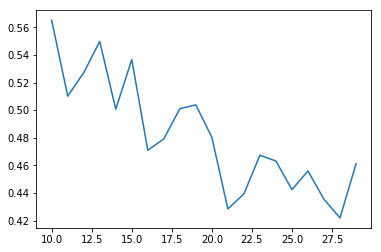

In [87]:
plt.plot(n_topics, coherence_values)
plt.show()

In [88]:
best_model = model_list[np.argmax(coherence_values)]

In [90]:
## get number of topics for the model 
n_topics = best_model.get_topics().shape[0]

In [91]:
print_topics_gensim(topic_model=best_model,
                   total_topics = n_topics,
                   num_terms=10,
                   display_weights=True) 

Topic #1 with weights
[('bank', 0.0211), ('credit', 0.0189), ('risk', 0.013), ('loan', 0.0126), ('asset', 0.0113), ('liquidity', 0.011), ('deposit', 0.0103), ('banking_system', 0.01), ('market', 0.0094), ('banking', 0.0093)]
Topic #2 with weights
[('gdp', 0.0122), ('debt', 0.012), ('fiscal', 0.0099), ('revenue', 0.0072), ('project', 0.0068), ('deficit', 0.0067), ('budget', 0.0066), ('increase', 0.0061), ('spending', 0.0061), ('expenditure', 0.0058)]
Topic #3 with weights
[('ii_general_resources', 0.0295), ('lebanon', 0.0234), ('sta', 0.0169), ('npv', 0.0149), ('lesotho', 0.014), ('psi', 0.0115), ('license', 0.0107), ('hipc_initiative_not_applicable', 0.0104), ('swaziland', 0.0095), ('x._exchange', 0.0086)]
Topic #4 with weights
[('fund_imf_conclude', 0.0432), ('article_iv_consultation', 0.031), ('board_discussion', 0.0266), ('issue_after_executive', 0.0235), ('executive_board', 0.0234), ('member_country', 0.0217), ('consent', 0.0135), ('fx', 0.0131), ('ex_post_assessment', 0.0127), ('e

In [92]:
lda_model_filepath = 'data/lda_res'
best_model.save(lda_model_filepath)

In [93]:
print(' '.join(paras[1]))

2 the authority have request a purchase under the rapid access component of the exogenous_shocks_facility rac_esf access under_the_rac_esf would support -PRON- effort to mitigate the adverse_impact of the global downturn on the economy the mission that visit castries during june 8 11 assess the immediate balance of payment need and review the authorities’ policy measure to address the sudden shock.1


In [94]:
best_model[corpus_tfidf[1]]

[(0, 0.08749806),
 (1, 0.24470736),
 (2, 0.011672979),
 (4, 0.010251766),
 (5, 0.0891507),
 (6, 0.35228854),
 (7, 0.16604398),
 (8, 0.010883795),
 (9, 0.018965589)]

In [95]:
# Our test document is document number 4310
for index, score in sorted(best_model[corpus_tfidf[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, best_model.print_topic(index, 10)))


Score: 0.352287620306015	 
Topic: 0.008*"reform" + 0.008*"authority" + 0.008*"sector" + 0.006*"financial" + 0.006*"policy" + 0.006*"improve" + 0.006*"tax" + 0.006*"need" + 0.005*"support" + 0.005*"strengthen"

Score: 0.24471807479858398	 
Topic: 0.012*"gdp" + 0.012*"debt" + 0.010*"fiscal" + 0.007*"revenue" + 0.007*"project" + 0.007*"deficit" + 0.007*"budget" + 0.006*"increase" + 0.006*"spending" + 0.006*"expenditure"

Score: 0.16603699326515198	 
Topic: 0.015*"growth" + 0.015*"rate" + 0.013*"exchange" + 0.012*"inflation" + 0.010*"price" + 0.009*"export" + 0.008*"remain" + 0.007*"strong" + 0.007*"economy" + 0.007*"external"

Score: 0.08914743363857269	 
Topic: 0.013*"report" + 0.013*"arrangement" + 0.011*"imf" + 0.009*"executive_board" + 0.008*"article_iv_consultation" + 0.008*"assessment" + 0.007*"discussion" + 0.007*"request" + 0.007*"complete" + 0.007*"review"

Score: 0.08749852329492569	 
Topic: 0.021*"bank" + 0.019*"credit" + 0.013*"risk" + 0.013*"loan" + 0.011*"asset" + 0.011*"li

In [96]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [97]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_bow, dictionary,n_jobs=2)

D:\data\chengyu\basics\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [98]:
pyLDAvis.save_html(vis, './data/topic_lda.html')